# Franceschin CERIC beamtime @ SYRMEP Elettra
## Image processing of corroded pit - PART 1

1. Load reconstructed 3D volume
2. Whole pit mask; pit boundary mask
3. Crystals mask
4. Study size and sphericity of pearls with `porespy`

Created on:  22.04.2022 <br />
Last update: 25.04.2022 <br />

In [1]:
%%html
<style> table {float:left} </style>

|Scan parameters|   |
|:-|:-|
|Beamline|SYRMEP@Elettra|
|Sample|581681_patina/581681_punta_HR_stitch2 |
|Energy| 27 keV |
|Camera| ORCA flash |
|Voxel size| 1.0 um |
|SDD | 150 mm |
|Preliminary operations|stitch of 4 scans (normalized; 2D rigid transform) |

## 0. Configuration

In [2]:
import sys
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
# sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

In [6]:
import numpy as np
# import dxchange
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage, misc
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
from imaging_utils import remove_unconnected, remove_largest

In [4]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

## 00. Load input data
For practical reasons we load a small portion (100 slices) of the reconstructed dataset: slices [4100, 4199]

In [5]:
# input_file = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/slices/slice_0000.tif'
input_file = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/100slices/slice_4101.tif'

In [6]:
data_3D = read_tiff_stack(input_file, [4100, 4199])

Voxelsize:

In [ ]:
vs = np.ones(3)*1.0e-3 # [mm]

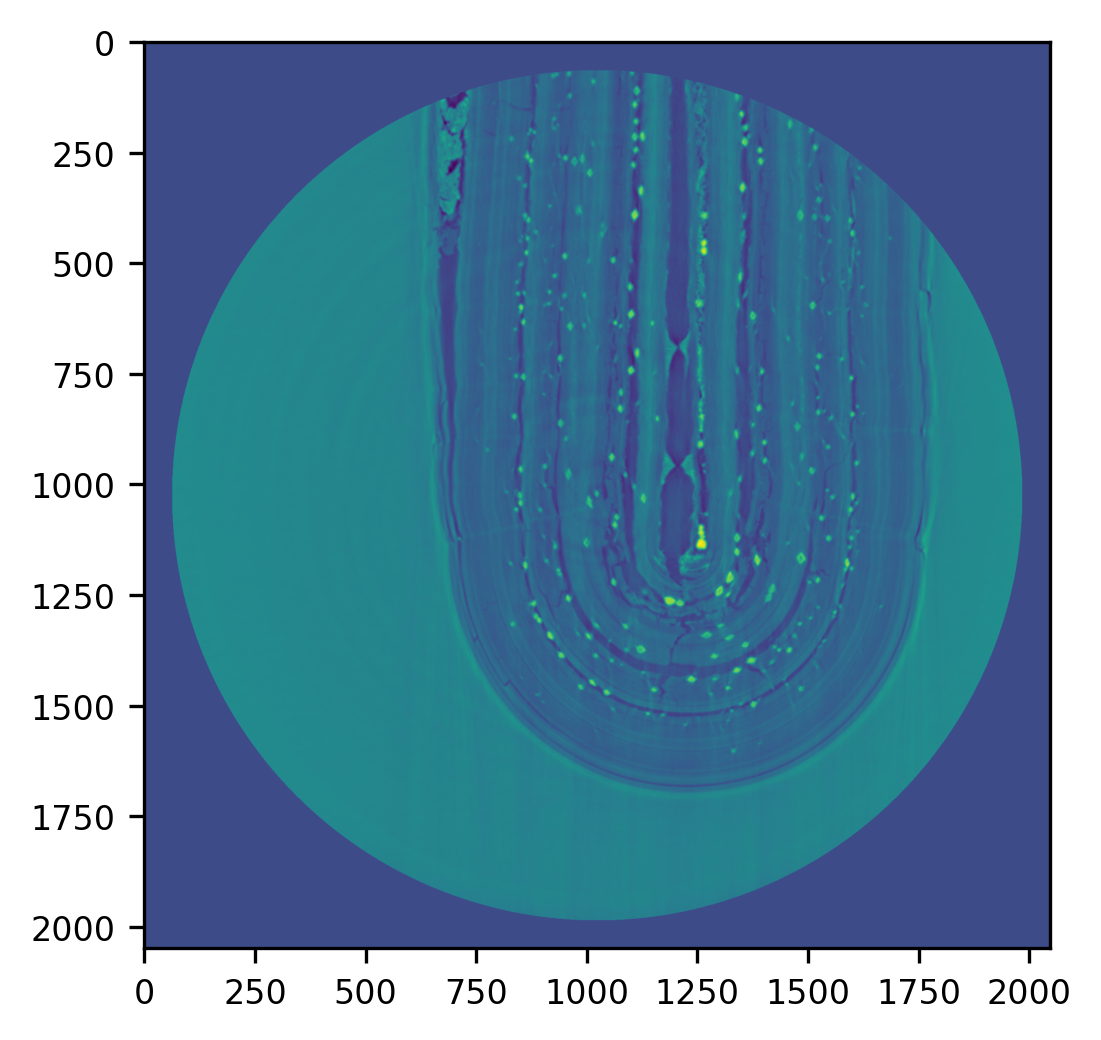

In [8]:
# Inspect slice
plt.imshow(data_3D[20,:,:])

## 1. Pre-processing
### 1.1. Gaussian smooth (don't)

In [8]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### 1.2. Resize (don't)

In [48]:
resampling = 1.2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

In [ ]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

## 2. Pit region and boundary masks

A binary mask of the corroded **pit region** was obtained in the following way:
1. A cylindrical mask of the scanned area (`BW_circle`) was obtained selecting all voxels with `GV ~= 0`.
2. Layered structures of corroded glass (`BW_pit`) were segmented based on the image GV using lower and upper thresholds that were manualy selected.
3. All unconnected clusters of voxels were removed from `BW_pit`
4. A mask was computed as `~(BW_pit | BW_circle)`. This included the bulk, non-corroded glass, voids, and crystals with high intensity within the pit.
5. The largest region (bulk glass) was removed `remove_largest(~(BW_pit | BW_circle))` leaving only voids and crystals within the pit (`BW_holes_within_pit`).
6. `BW_holes_within_pit` and `BW_pit` were merged to close all voids within the pit region: `BW_pit = BW_pit | BW_holes_within_pit`.
7. A further step of holes filling was applied to `BW_pit`.
5. Remaining voids within the pit region were isolated as follows:

A mask of the **pit boundary** was then obtained from the intersection of `BW_pit` and the inverse of its erosion (`~ndimage.binary_erosion(BW_pit, morphology.ball(1), border_value=1)`)

The **pit bottom** mask is obtained removing the part of the pit boundary in the direction of the sample surface. This is done with an erosion step on the background circle mask:
`BW_pit_bottom = BW_pit_boundary & ndimage.binary_erosion(~BW_circle, morphology.ball(1), border_value=True)`

**Crystal precipitations** are segmented applying a single lower threshold that was selected manually.

### 2.0. circle mask

In [7]:
BW_circle = data_3D == 0

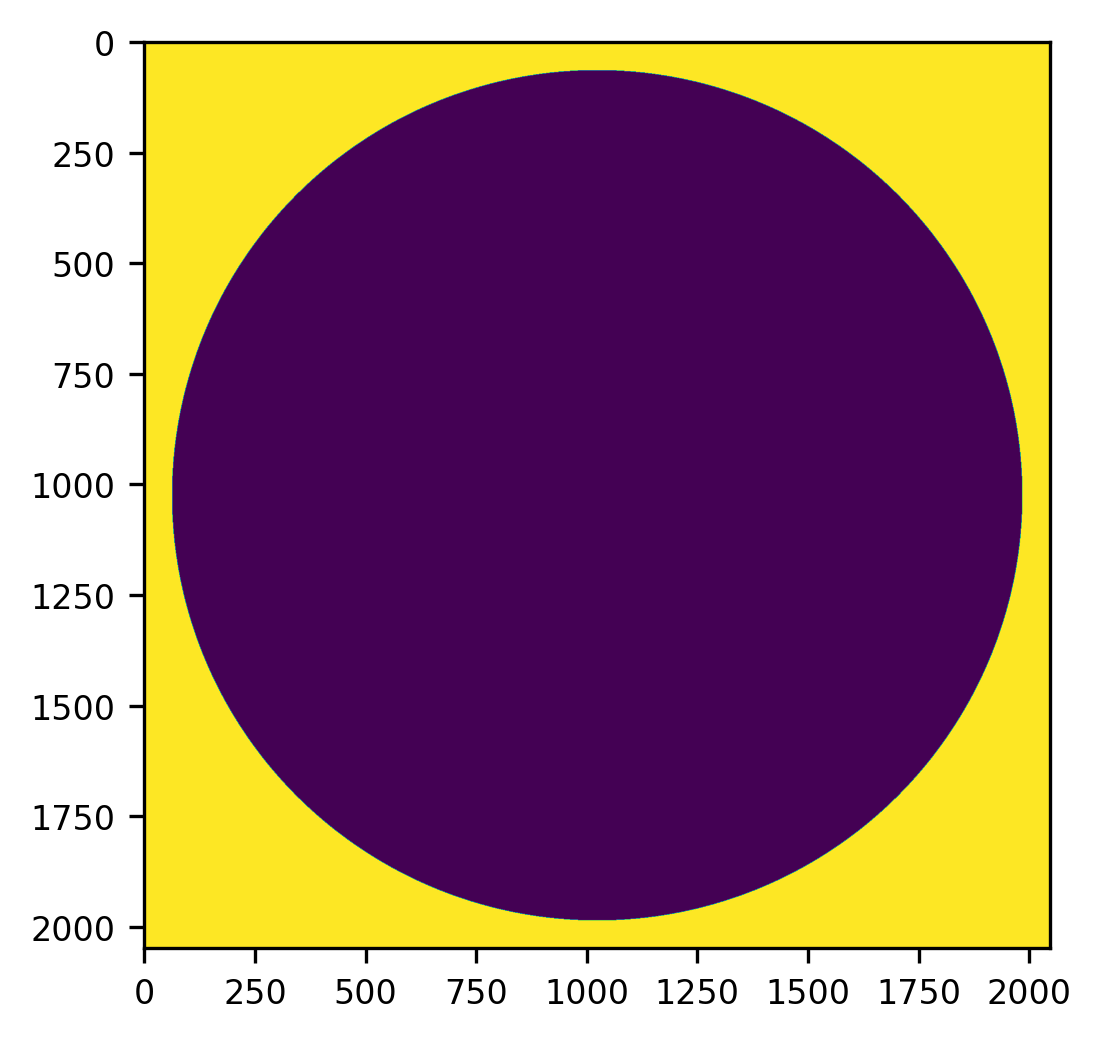

In [10]:
plt.imshow(BW_circle[20,:,:])

### 2.1. pit mask
2.1.1. Filter based on GV

In [8]:
BW_pit = (data_3D>0.000264) & (data_3D<0.00159)

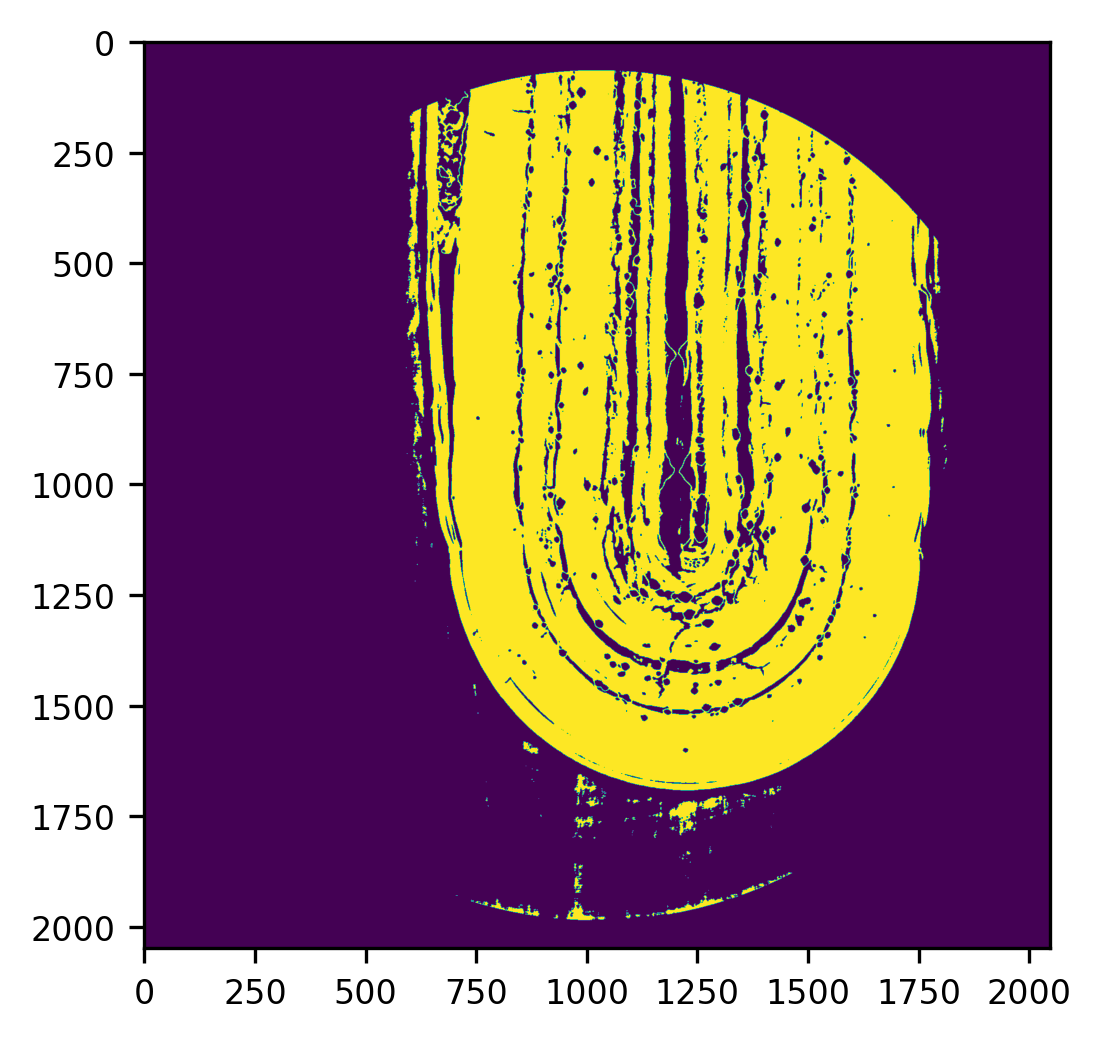

In [28]:
plt.imshow(BW_pit[0,:,:])

2.1.2. Image open to remove circle (don't)

In [9]:
# BW_pit = morphology.binary_opening(BW_pit, morphology.cube(2))

2.1.3. Fill holes within pit (don't)

In [13]:
# BW_pit = ndimage.binary_fill_holes(BW_pit)

2.1.4. Remove unconnected struts

In [9]:
BW_pit = remove_unconnected(BW_pit)

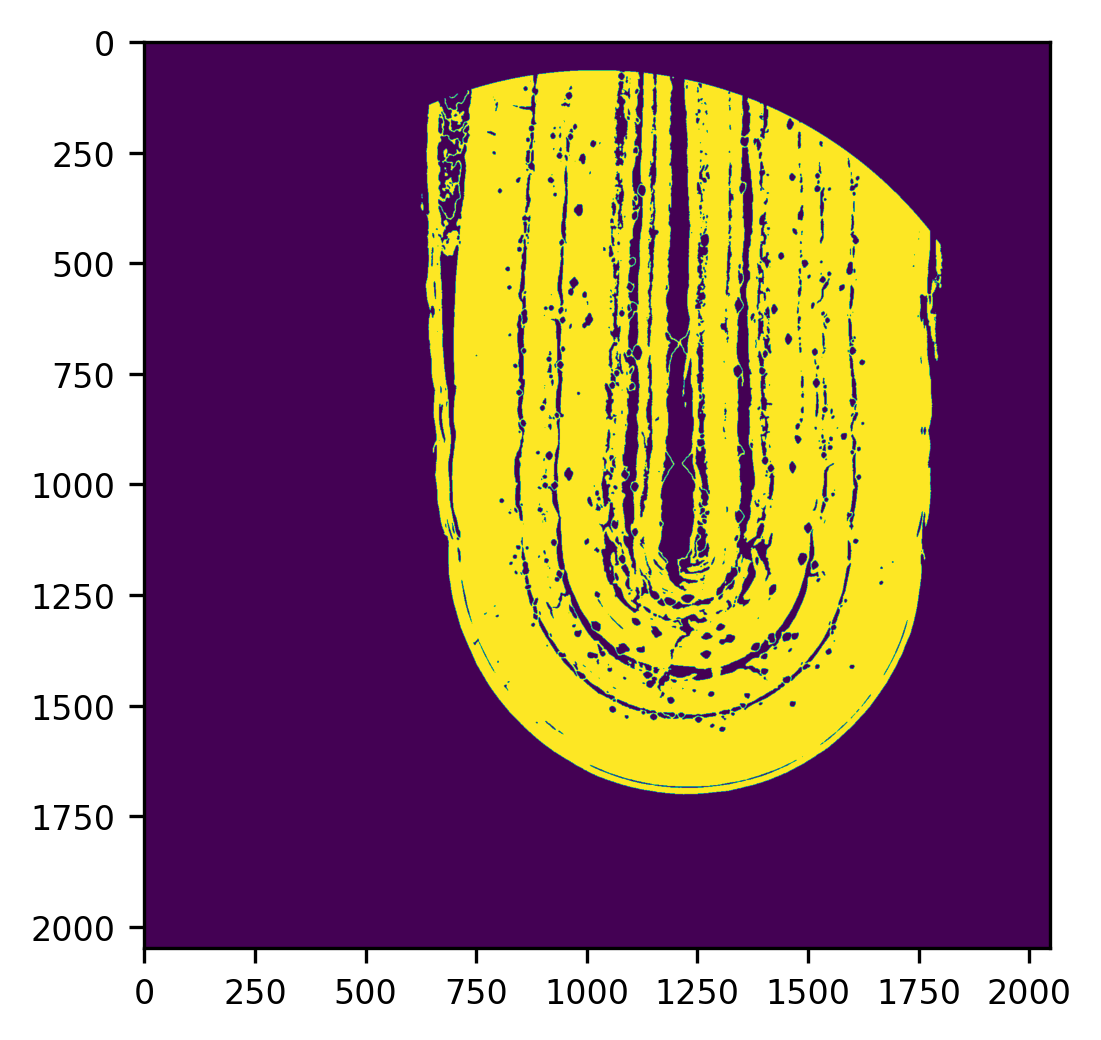

In [10]:
plt.imshow(BW_pit[50,:,:])

2.1.5. Close open surface of the pit with the cirle mask (don't)

In [48]:
# BW_pit2 = BW_pit & morphology.binary_dilation(BW_circle, morphology.cube(5))

In [98]:
# BW_pit2 = ndimage.binary_closing(~(BW_pit | BW_circle), morphology.cube(3), iterations=3 border_value=1)

2.1.6. Find holes within pit

In [11]:
BW_holes_within_pit = remove_largest(~(BW_pit | BW_circle))

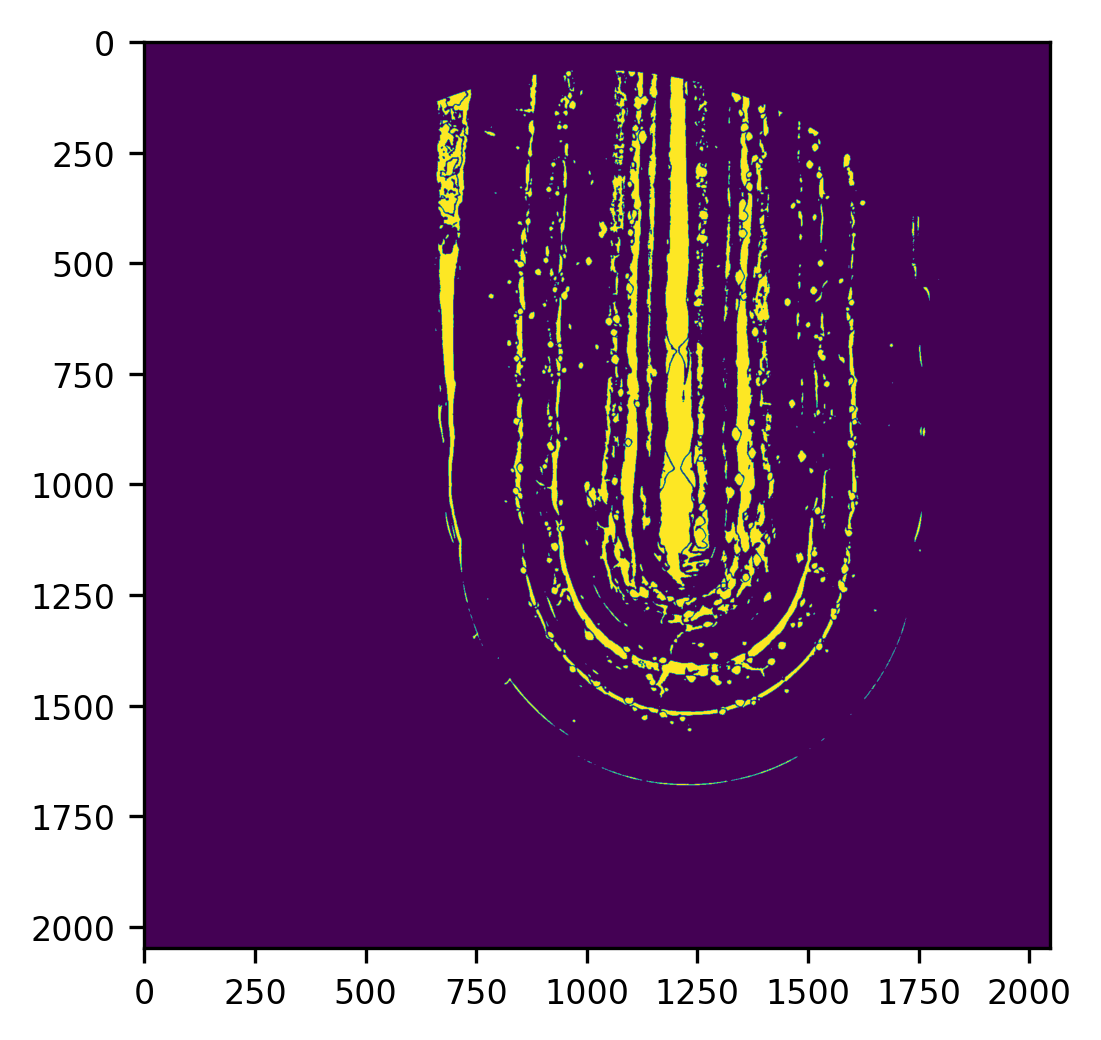

In [32]:
plt.imshow(BW_holes_within_pit[10,:,:])

2.1.7. Pit mask (holes removed)

In [12]:
BW_pit = BW_pit | BW_holes_within_pit

2.1.8. Image closing (optional)

In [13]:
BW_pit = ndimage.binary_closing(BW_pit, morphology.ball(1), iterations=5, border_value=1)

2.1.9. Followed by holes removal

In [14]:
BW_pit = ~remove_unconnected(~BW_pit)

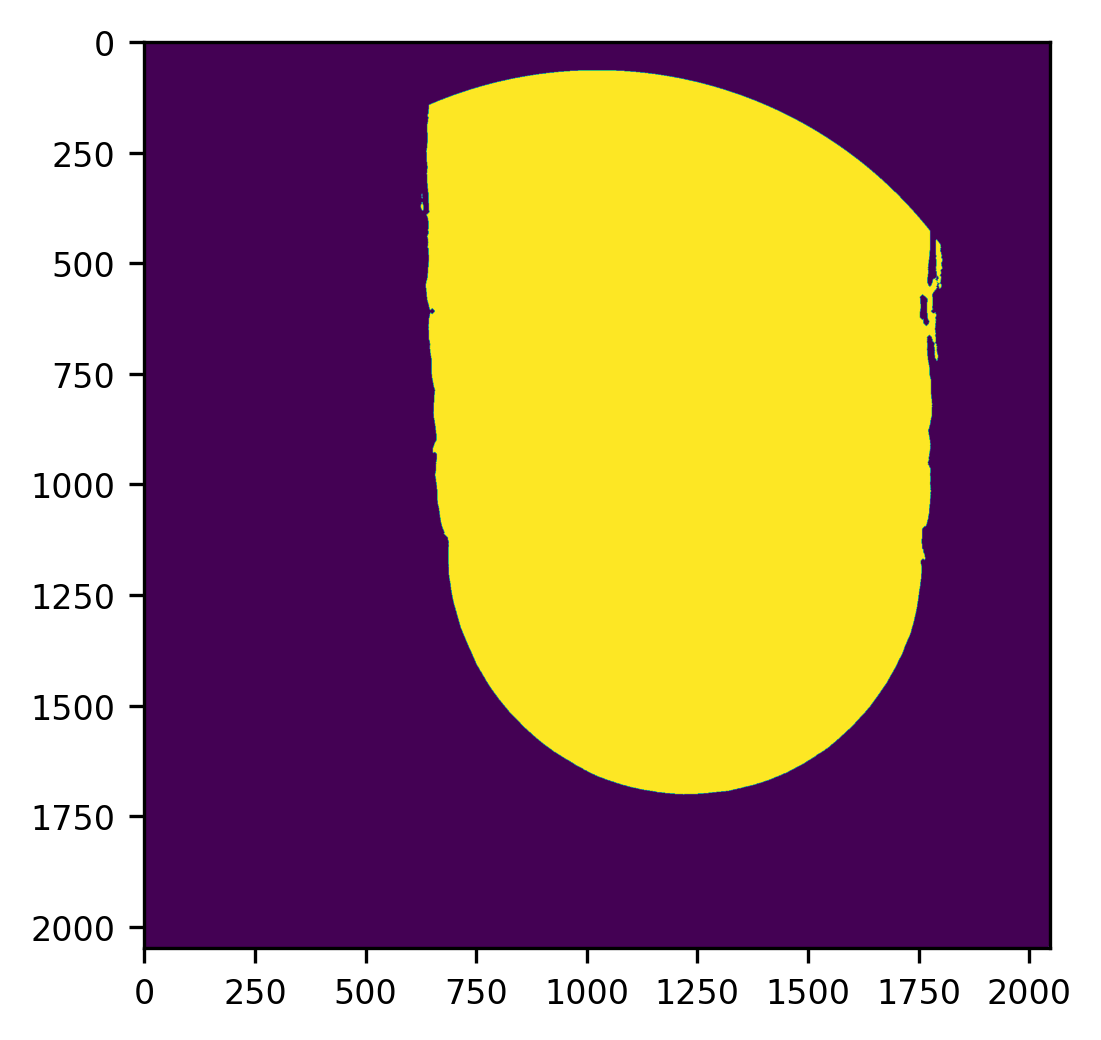

In [17]:
plt.imshow(BW_pit[50,:,:])

### 2.2. Pit boundary mask

In [15]:
BW_pit_boundary = BW_pit & ~ndimage.binary_erosion(BW_pit, morphology.ball(1), border_value=1)

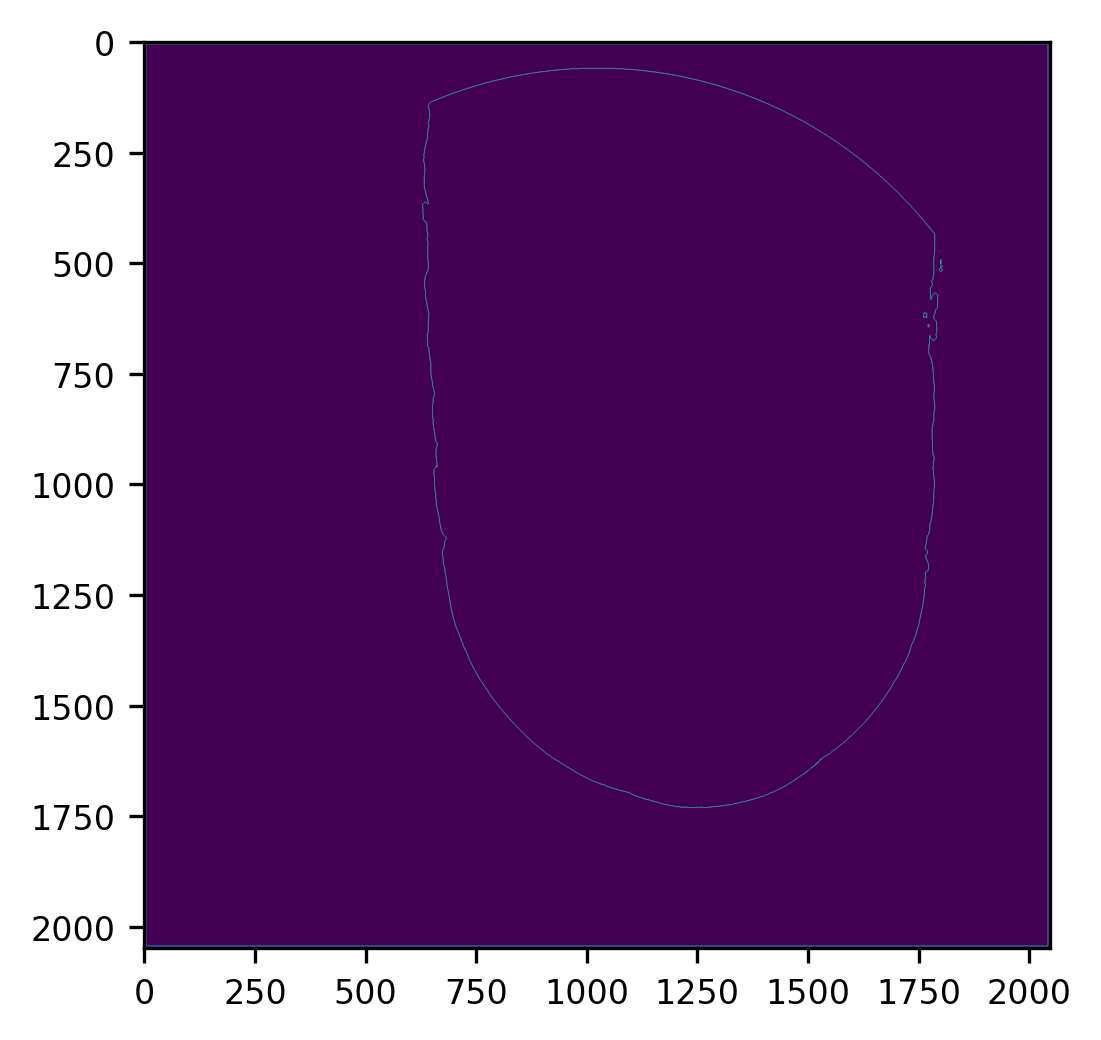

In [27]:
plt.imshow(BW_pit_boundary[98,:,:])

### 2.3. Remove boundary portion of the pit exposed to air
Remove the top of the pit by eroding the circle mask

In [29]:
BW_pit_bottom = BW_pit_boundary & ndimage.binary_erosion(~BW_circle, morphology.ball(1), border_value=True)

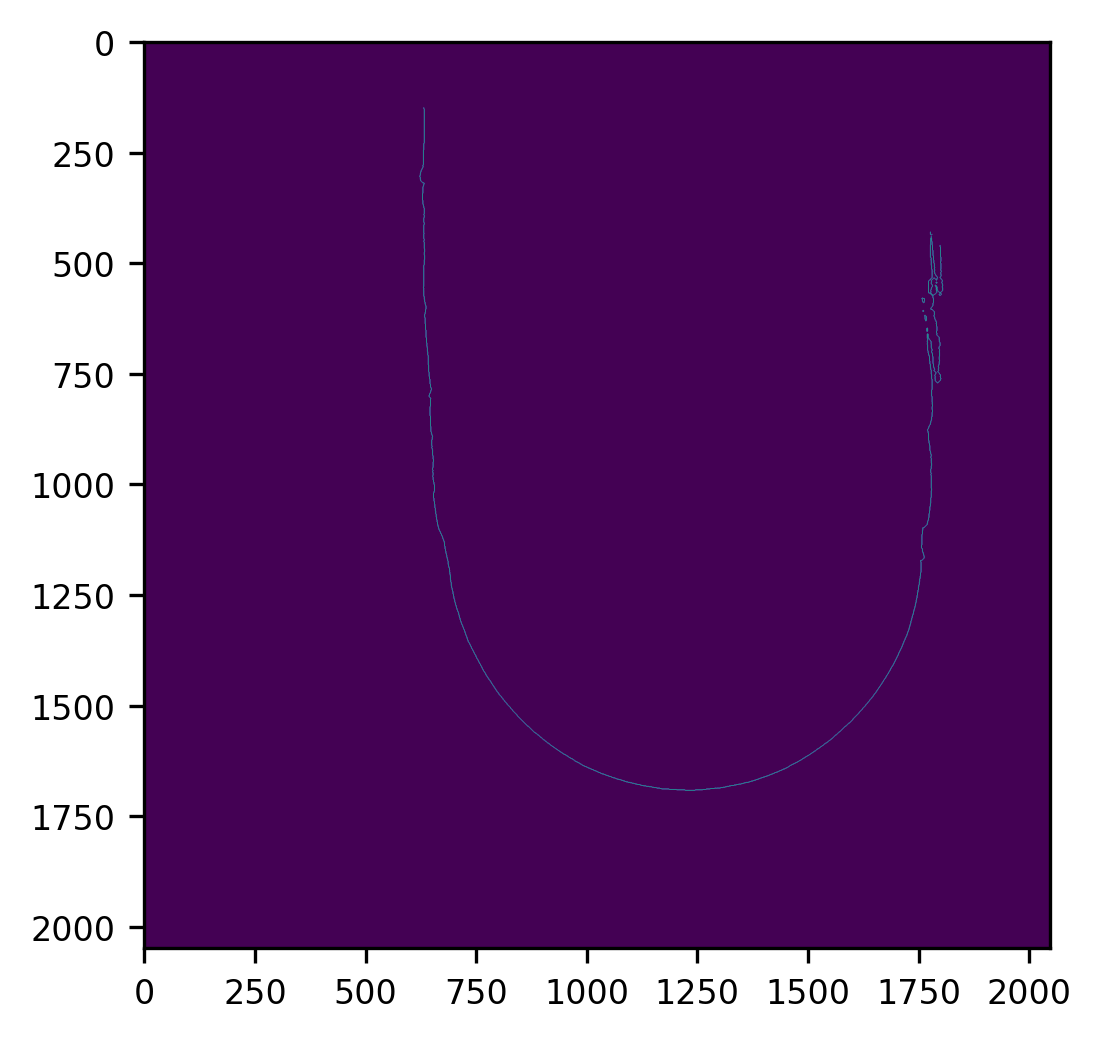

In [31]:
plt.imshow(BW_pit_bottom[0,:,:])

2.4. Save mask as a stack of tiffs with `dxchange`

In [32]:
import dxchange

In [33]:
dxchange.write_tiff_stack(BW_pit_bottom, "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_pit_bottom/slice.tiff")

## 3. Mask perline
3.1. Select highly mineralized regions from their GV (brightest histogram tail..)

In [20]:
BW_pearls = data_3D>0.0022

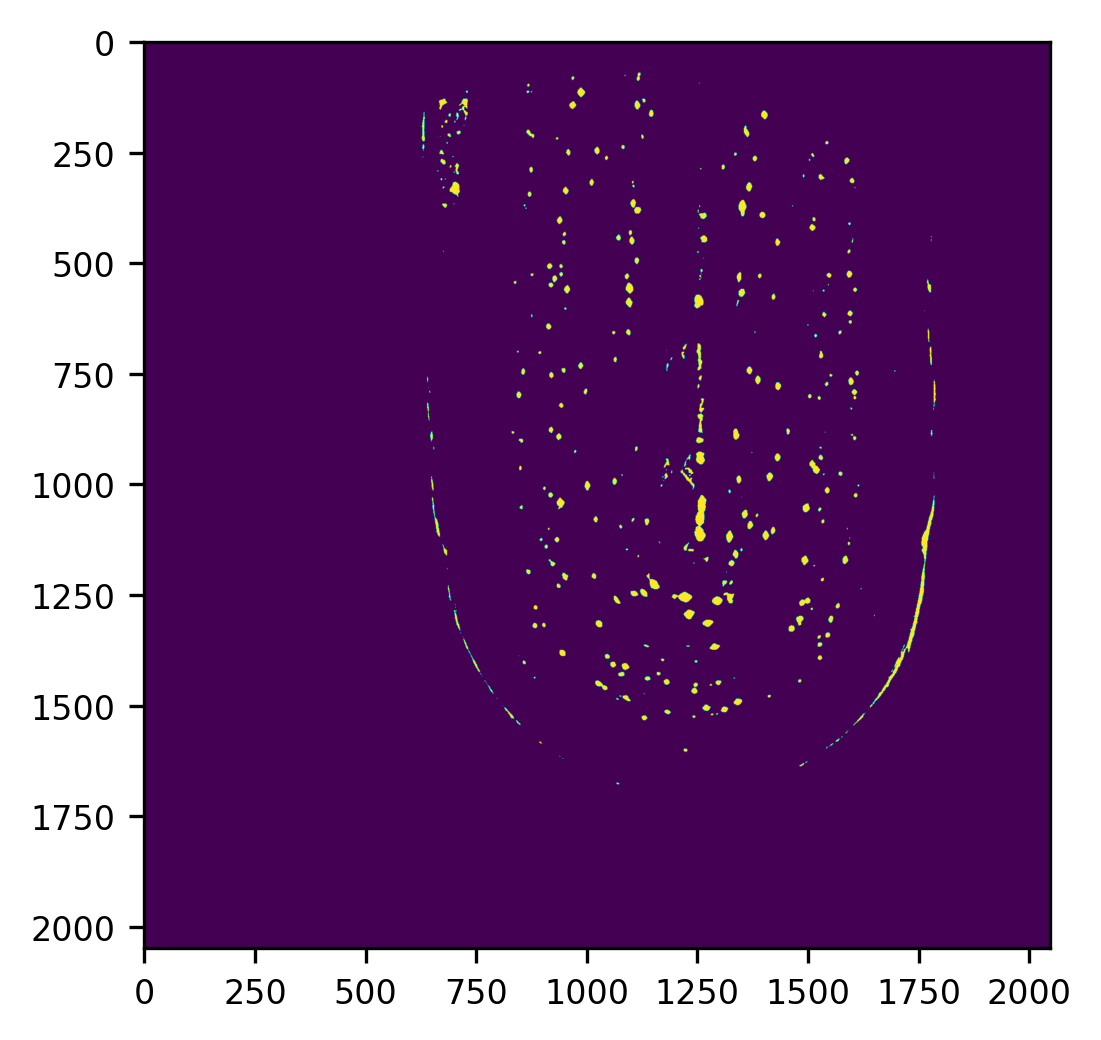

In [20]:
plt.imshow(BW_pearls[20,:,:])

3.2. Remove outer pit stuff by applying eroded pit mask

In [21]:
BW_pearls = BW_pearls & ndimage.binary_erosion(BW_pit, morphology.ball(1), iterations=30, border_value=1)

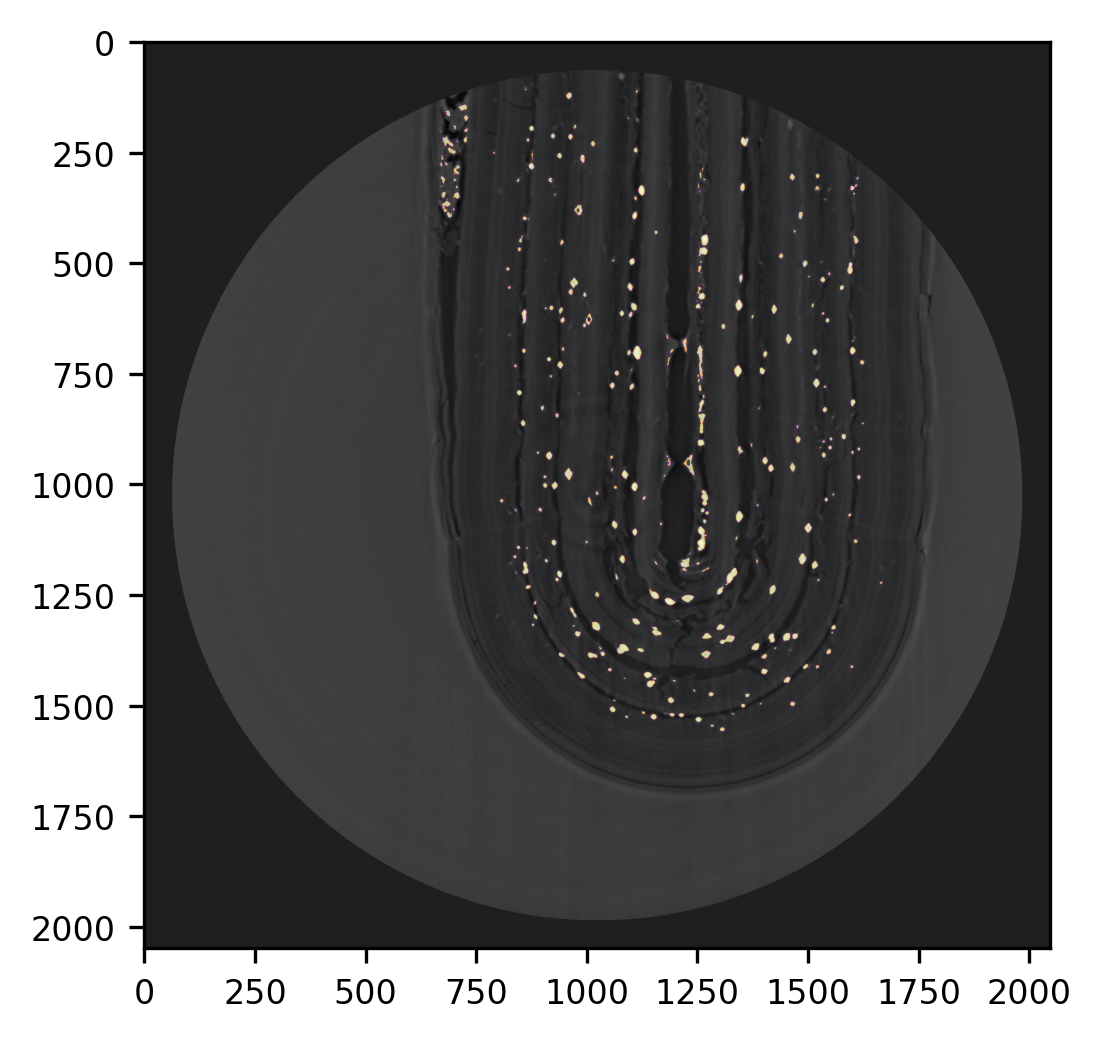

In [22]:
plt.imshow(data_3D[50,:,:], cmap='gray')
plt.imshow(BW_pearls[50,:,:], cmap='inferno', alpha=0.5)

3.3. Save pearls mask - Save stack of tiffs with `dxchange`

In [24]:
dxchange.write_tiff_stack(BW_pearls, "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/masks/100slices_pearls/slice.tiff")

___
# STOP HERE

### 3.3. apply watershed or snow algorithm to separate glued pearls
(not implemented yet..)

## 4.0. regionprops pearls
4.1. Apply scikit image labelling

In [52]:
regions = ndimage.label(BW_pearls)[0]

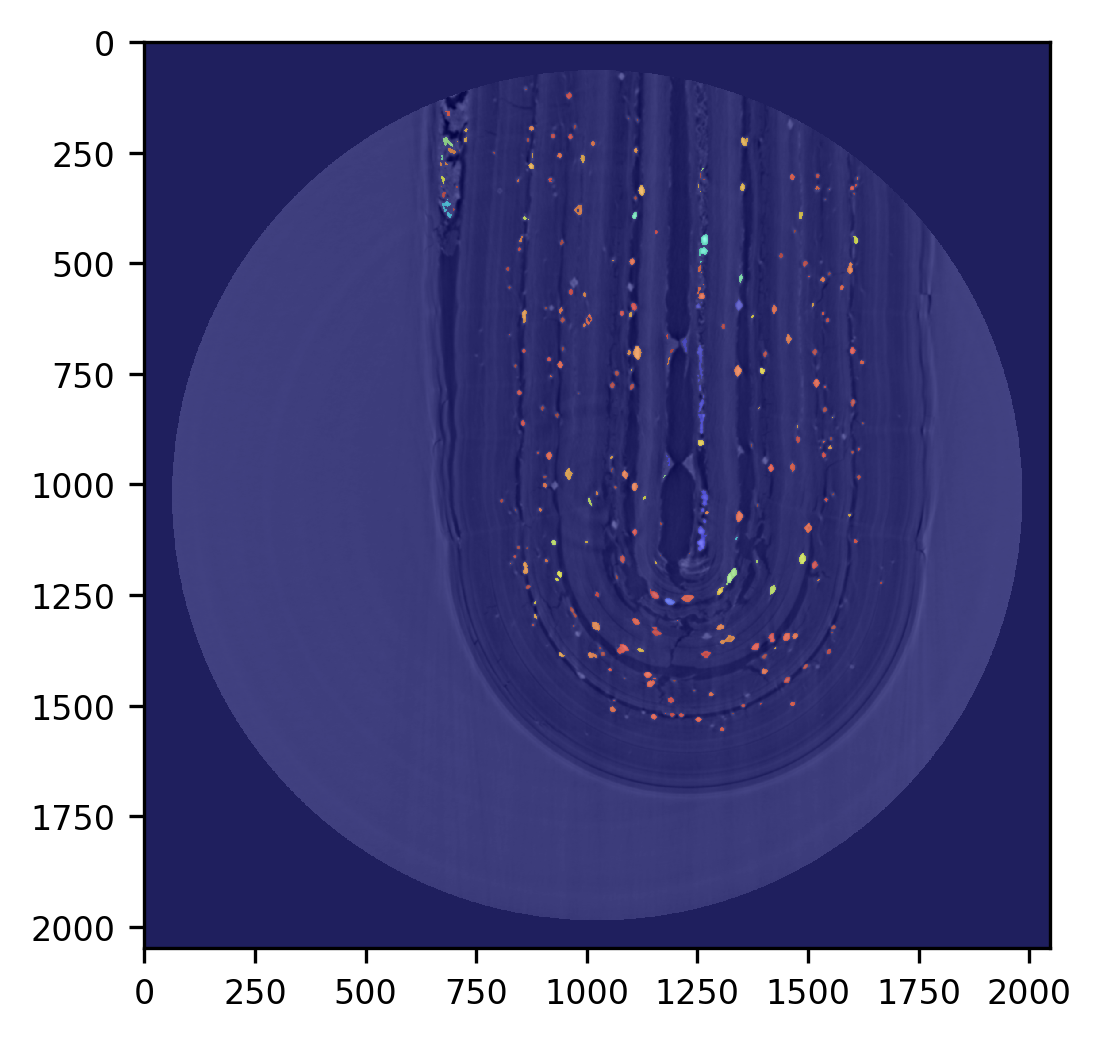

In [51]:
plt.imshow(data_3D[50,:,:], cmap='gray', interpolation='none')
plt.imshow(regions[50,:,:], cmap='jet', alpha=0.5, interpolation='none') # 'tab20c'

4.2. porespy regionprops_3D 

props is a list of RegionProperties objects, subclassed from scikit-image. Each RegionProperties object possess the properties as attributes. Note that these are calculated on demand, so the regionsprops_3D function appears very quick, but the work has not yet been done.

In [25]:
import porespy as ps

In [53]:
props = ps.metrics.regionprops_3D(regions)

Inspecting some of the props for specific pearls..

In [176]:
print(props[20].volume)

772


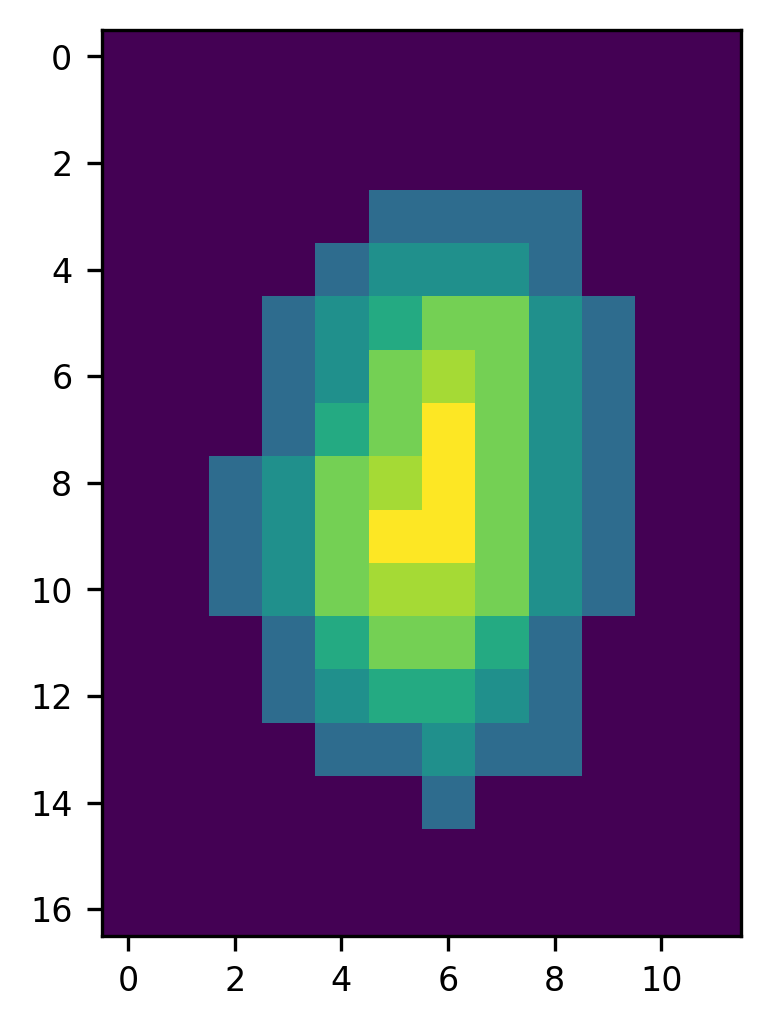

In [165]:
plt.imshow(props[20].dt[5, ...]);

4.3. Create dataframe of the measured props

In [ ]:
df = ps.metrics.props_to_DataFrame(props)

In [28]:
df.head()

,label,volume,bbox_volume,sphericity,surface_area,convex_volume,area,area_bbox,area_convex,equivalent_diameter_area,euler_number,extent,area_filled,axis_major_length,solidity
0,1,1481,3960,0.926409,678.242310,1606,1481,3960,1606,14.142260,1,0.373990,1481,20.190025,0.922167
1,2,241,588,0.666929,280.812256,356,241,588,356,7.720987,1,0.409864,241,16.483868,0.676966
2,3,8023,31465,0.616060,3145.953613,12952,8023,31465,12952,24.837777,1,0.254982,8023,42.223853,0.619441
3,4,9225,67200,0.293510,7247.231445,41593,9225,67200,41593,26.020916,-3,0.137277,9225,68.207055,0.221792
4,5,2599,5400,0.932710,980.110840,2816,2599,5400,2816,17.058305,1,0.481296,2599,19.491430,0.922940


4.4. Take a look at the histograms of various props

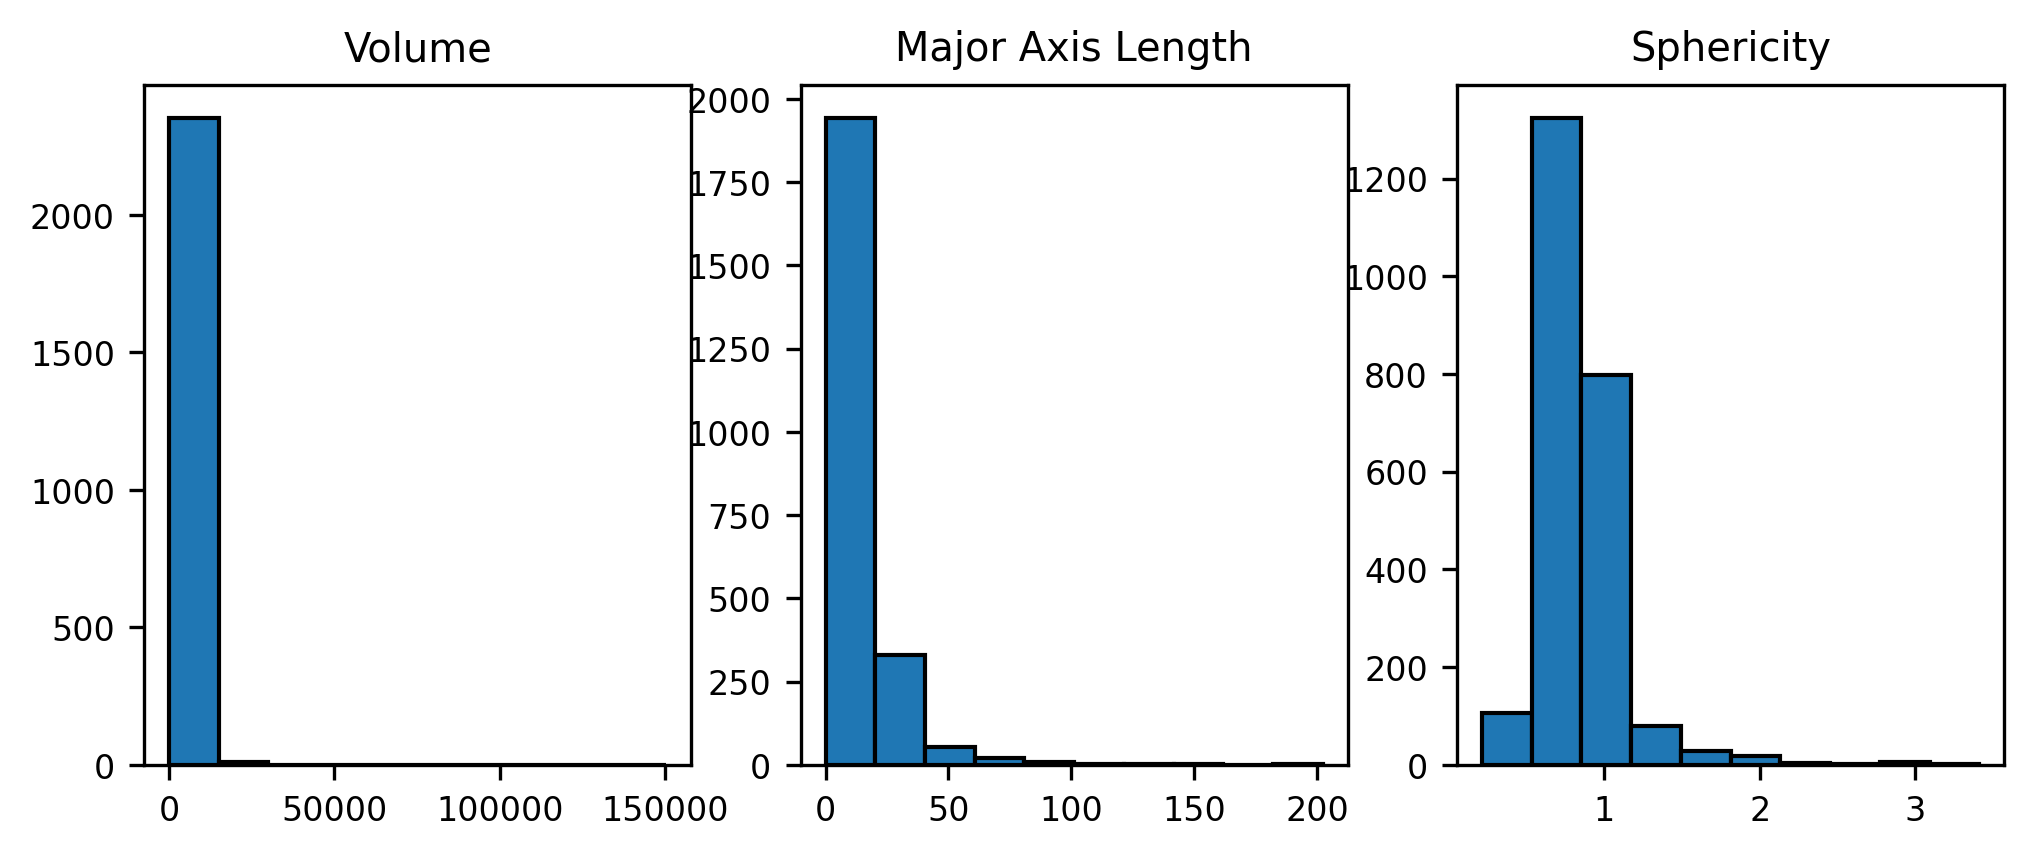

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(df['volume'], edgecolor="k")
ax[1].hist(df['axis_major_length'], edgecolor="k")
ax[2].hist(df['sphericity'], edgecolor="k");
ax[0].set_title("Volume")
ax[1].set_title("Major Axis Length")
ax[2].set_title("Sphericity");

### 4.5. Clean pearls mask based on regionprops_3D results
The high number of pearls with sphericity>1 is porbably due to cropped pearls connected to the top or bottom slices.
- We will select and remove from the mask all particles with sphericity>1 (no physical meaning)
- Another alternative would be to remove particles based on their size or major axis length

4.5.1. Find indexes of particles with `sphericity>1.0`

In [33]:
df_invalid = df[df['sphericity']>1.0]

In [46]:
df_invalid.head()

,label,volume,bbox_volume,sphericity,surface_area,convex_volume,area,area_bbox,area_convex,equivalent_diameter_area,euler_number,extent,area_filled,axis_major_length,solidity
9,10,56,98,1.135997,62.311131,60,56,98,60,4.746751,1,0.571429,56,7.603579,0.933333
10,11,10,12,1.619945,13.856405,0,10,12,0,2.673009,1,0.833333,10,4.582576,inf
16,17,2,2,1.108027,6.928203,0,2,2,0,1.563185,1,1.000000,2,2.236068,inf
18,19,31,48,1.270491,37.562420,34,31,48,34,3.897514,1,0.645833,31,4.637215,0.911765
19,20,119,216,1.024317,114.221458,130,119,216,130,6.102617,1,0.550926,119,9.117705,0.915385


In [97]:
df_invalid.iloc[-1]

label                       1136.000000
volume                        17.000000
bbox_volume                   20.000000
sphericity                     1.916291
surface_area                  16.684834
convex_volume                  0.000000
area                          17.000000
area_bbox                     20.000000
area_convex                    0.000000
equivalent_diameter_area       3.190192
euler_number                   1.000000
extent                         0.850000
area_filled                   17.000000
axis_major_length              6.054846
solidity                            inf
Name: 1135, dtype: float64

In [73]:
props[9].dt

array([[[0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

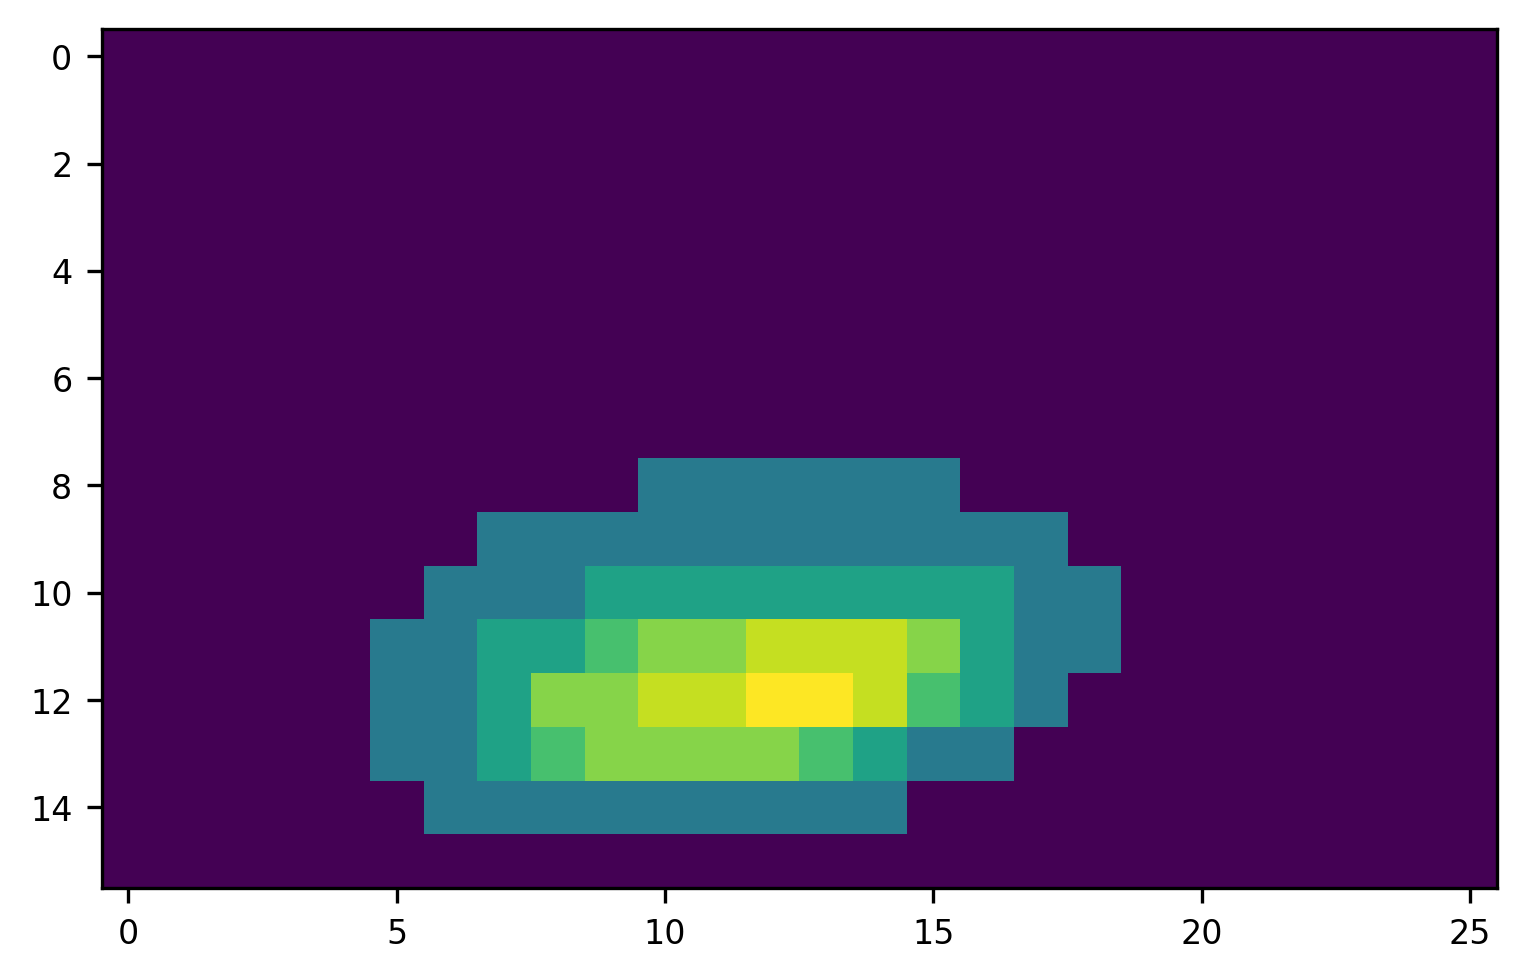

In [93]:
plt.imshow(props[245].dt[12, ...]);

Create mask of the pearls with sphericity>1

In [34]:
regions2 = np.zeros(regions.shape, dtype=np.uint8);
for label in df_invalid["label"]:
    regions2[regions == label-1] = 1

In [83]:
regions2 = np.zeros(regions.shape, dtype=np.float16);
for label in df_invalid["label"]:
    regions2[regions == label-1] = props[label-1].sphericity

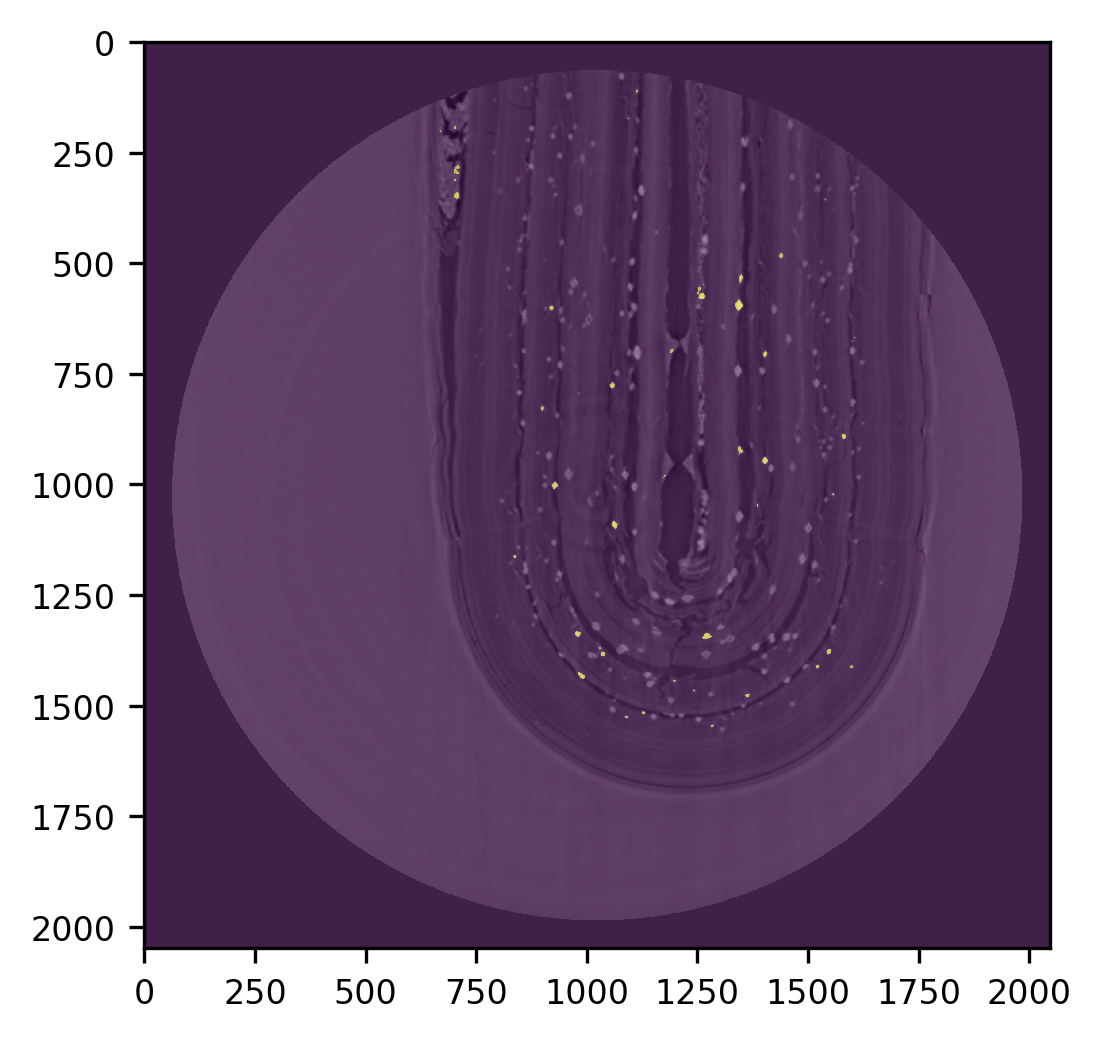

In [126]:
plt.imshow(data_3D[30,:,:], cmap='gray', interpolation='none')
plt.imshow(regions2[30,:,:], cmap='viridis', alpha=0.5, interpolation='none') # 'tab20c'

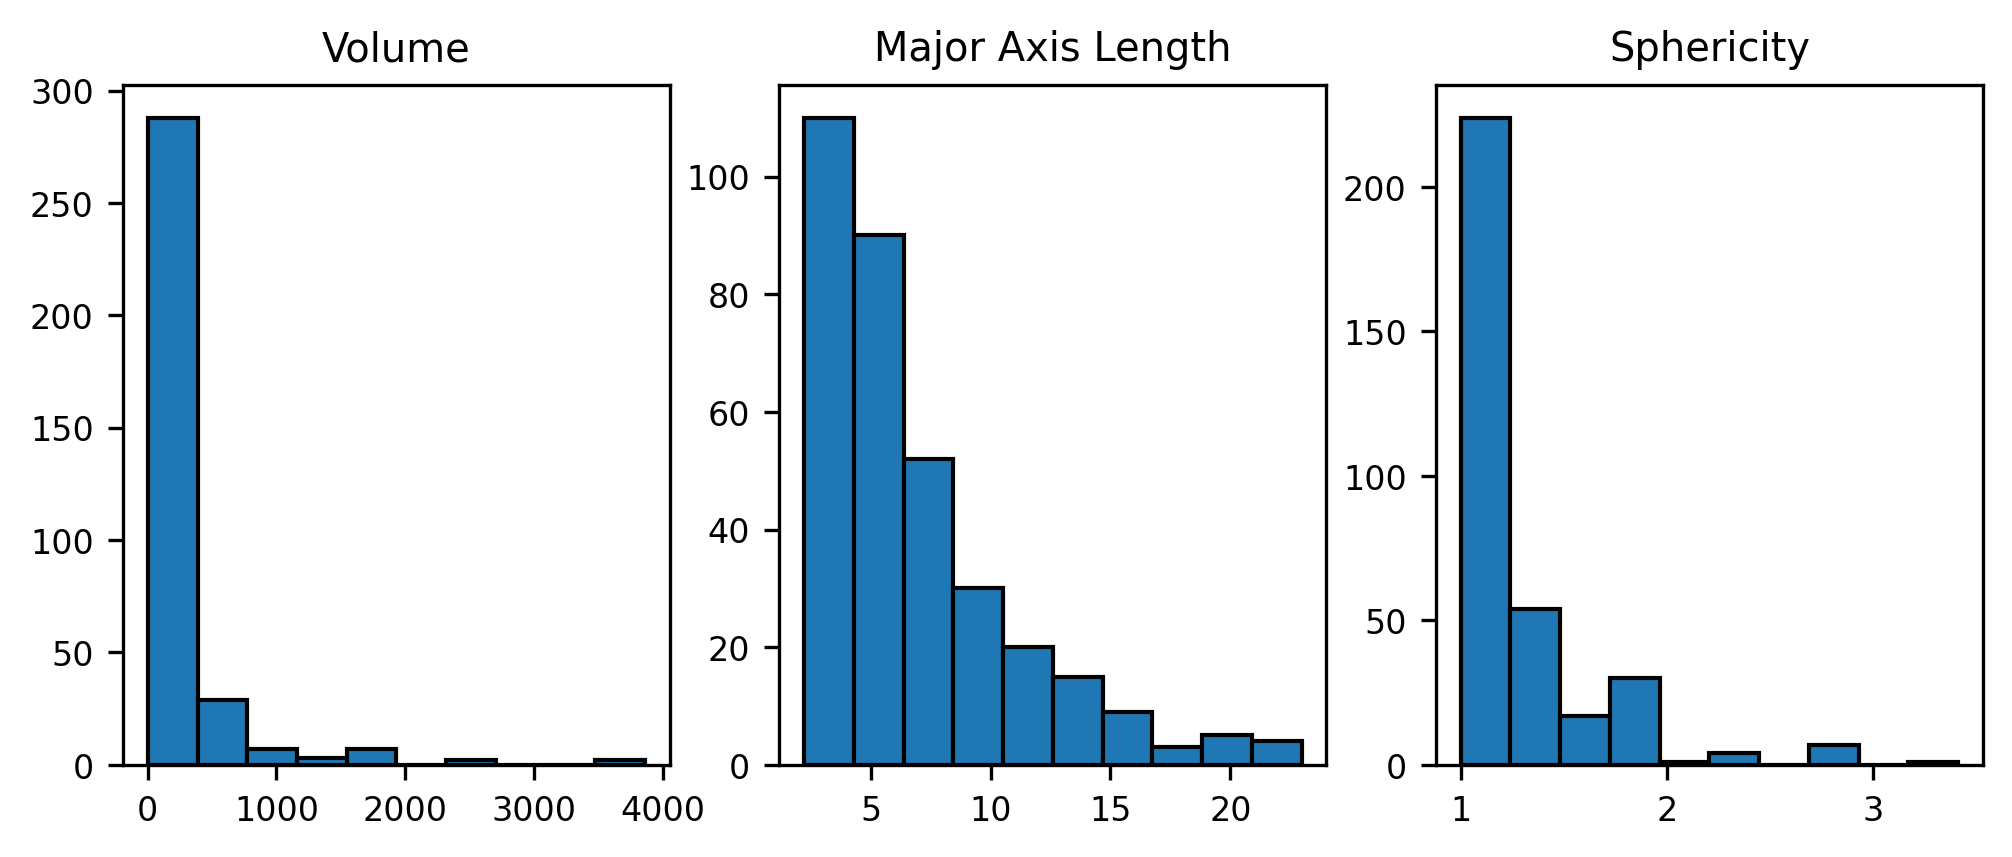

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(df_invalid['volume'], edgecolor="k")
ax[1].hist(df_invalid['axis_major_length'], edgecolor="k")
ax[2].hist(df_invalid['sphericity'], edgecolor="k");
ax[0].set_title("Volume")
ax[1].set_title("Major Axis Length")
ax[2].set_title("Sphericity");

4.5.2. Blank out invalid pearls

In [46]:
for label in df_invalid["label"]:
    regions[regions == label-1] = 0

### 4.6. filter dataframe of only valid pearls

In [55]:
df = df[df['sphericity']<=1.0]

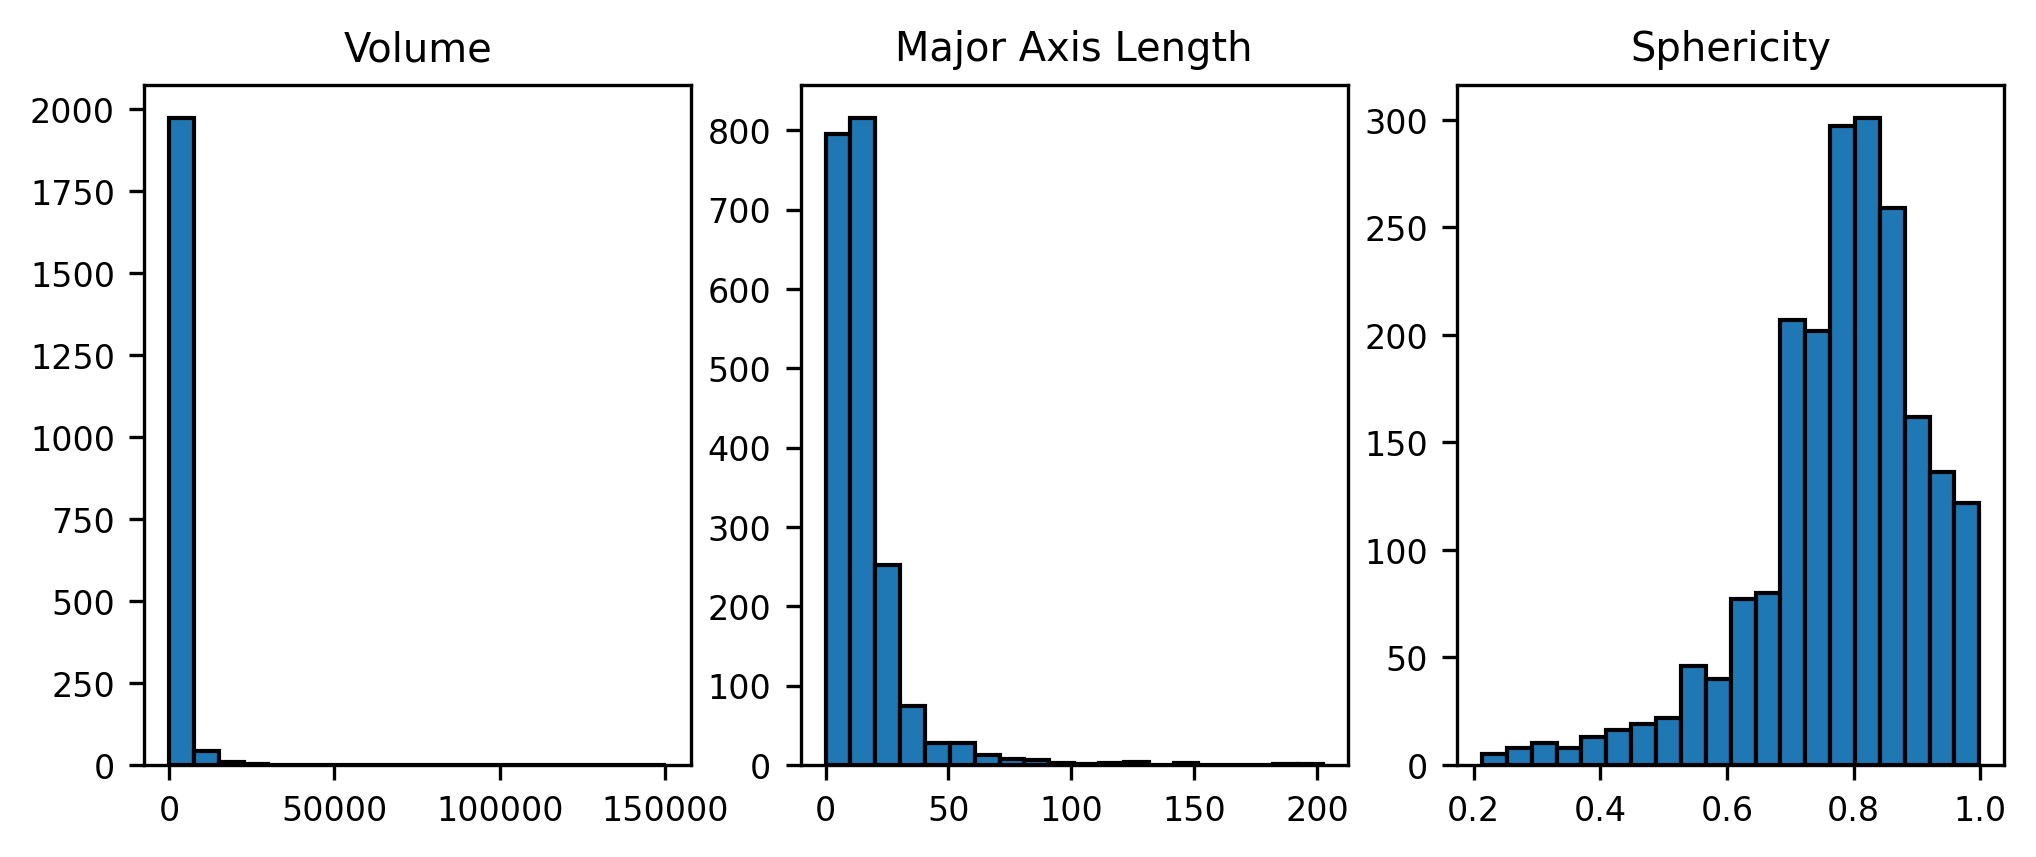

In [65]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(df['volume'], edgecolor="k", bins=20)
ax[1].hist(df['axis_major_length'], edgecolor="k", bins=20)
ax[2].hist(df['sphericity'], edgecolor="k", bins=20);
ax[0].set_title("Volume")
ax[1].set_title("Major Axis Length")
ax[2].set_title("Sphericity");

### 4.7. Sphericity VS particle size

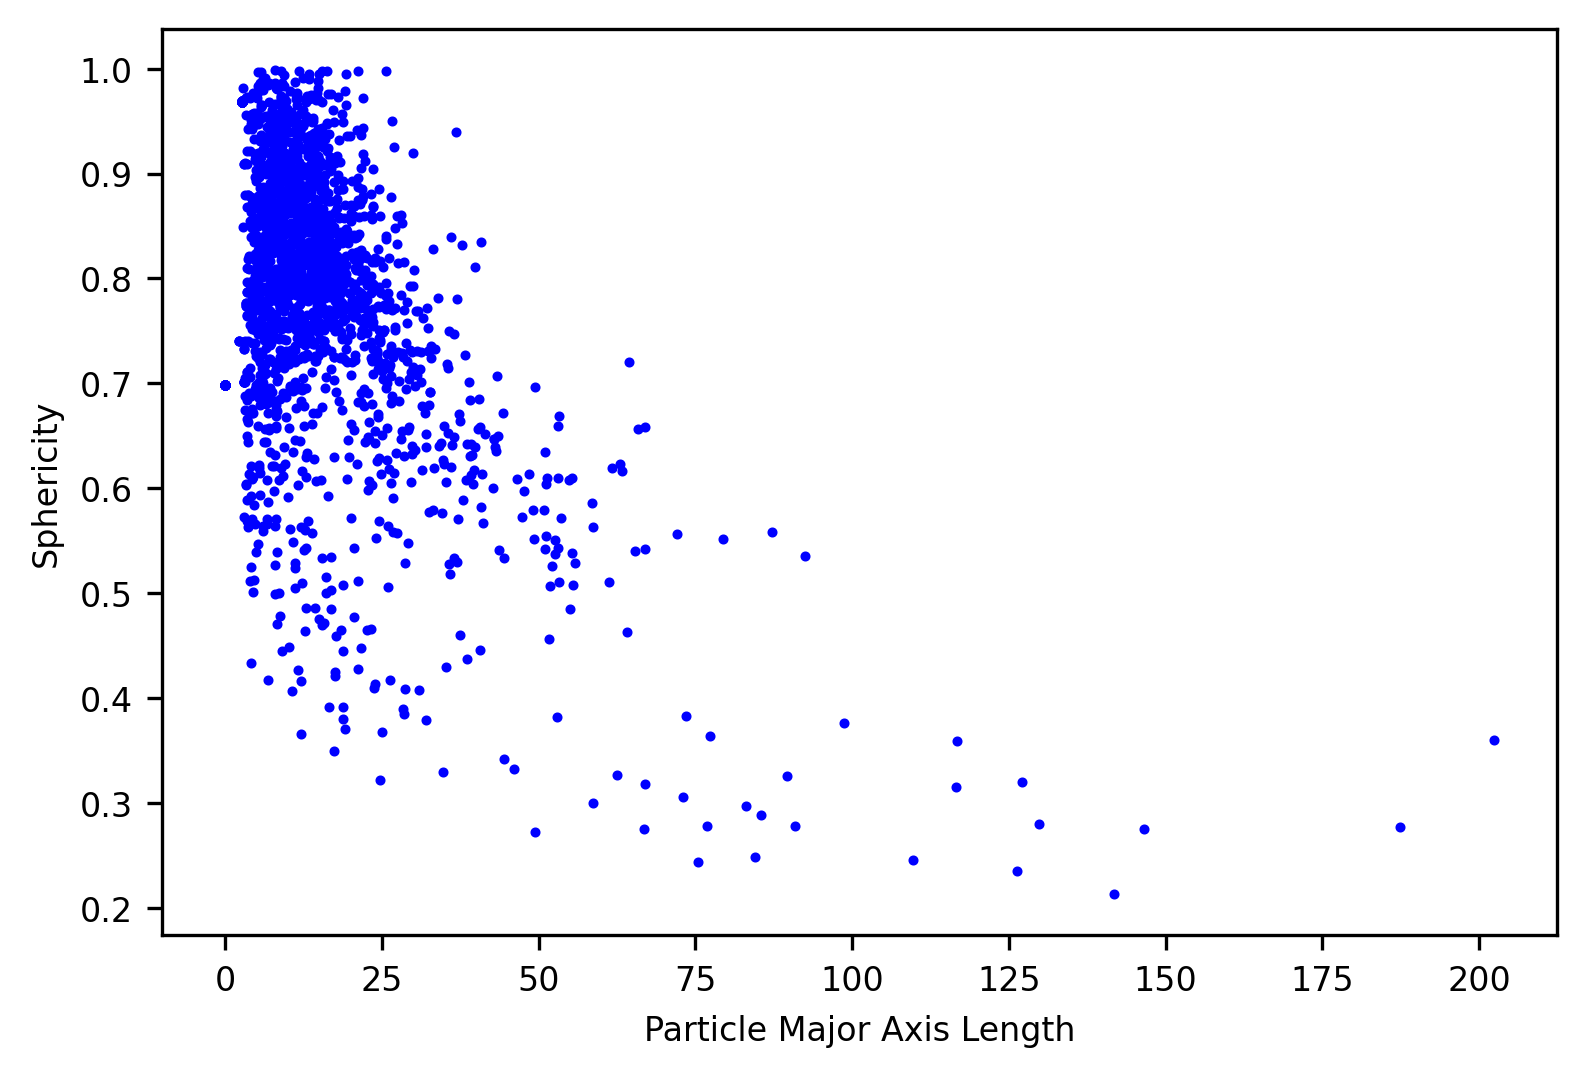

In [60]:
plt.scatter(df['axis_major_length'], df['sphericity'], s=2, c="b")
plt.xlabel("Particle Major Axis Length")
plt.ylabel("Sphericity")
plt.show()

### 4.8. Analyze histogram of sphericity
Probability Density Estimate of sphericity

#### To Do:
1. [X] remove particles with sphericity > 1
2. [ ] remove elongated particles based on sphericity? major axis length? 
3. [X] filter regionprops_3D dataframe based on (sphericity<1)
4. [X] plot sphericity VS particle size
5. [X] plot sphericity probability density f
6. [ ] particle orientation

![sphericity](Sphericity-of-particles-of-regular-form.png)

In [68]:
from scipy import stats

kde = stats.gaussian_kde(df['sphericity'])
x = np.linspace(df['sphericity'].min(), df['sphericity'].max(), 100)
p = kde(x)

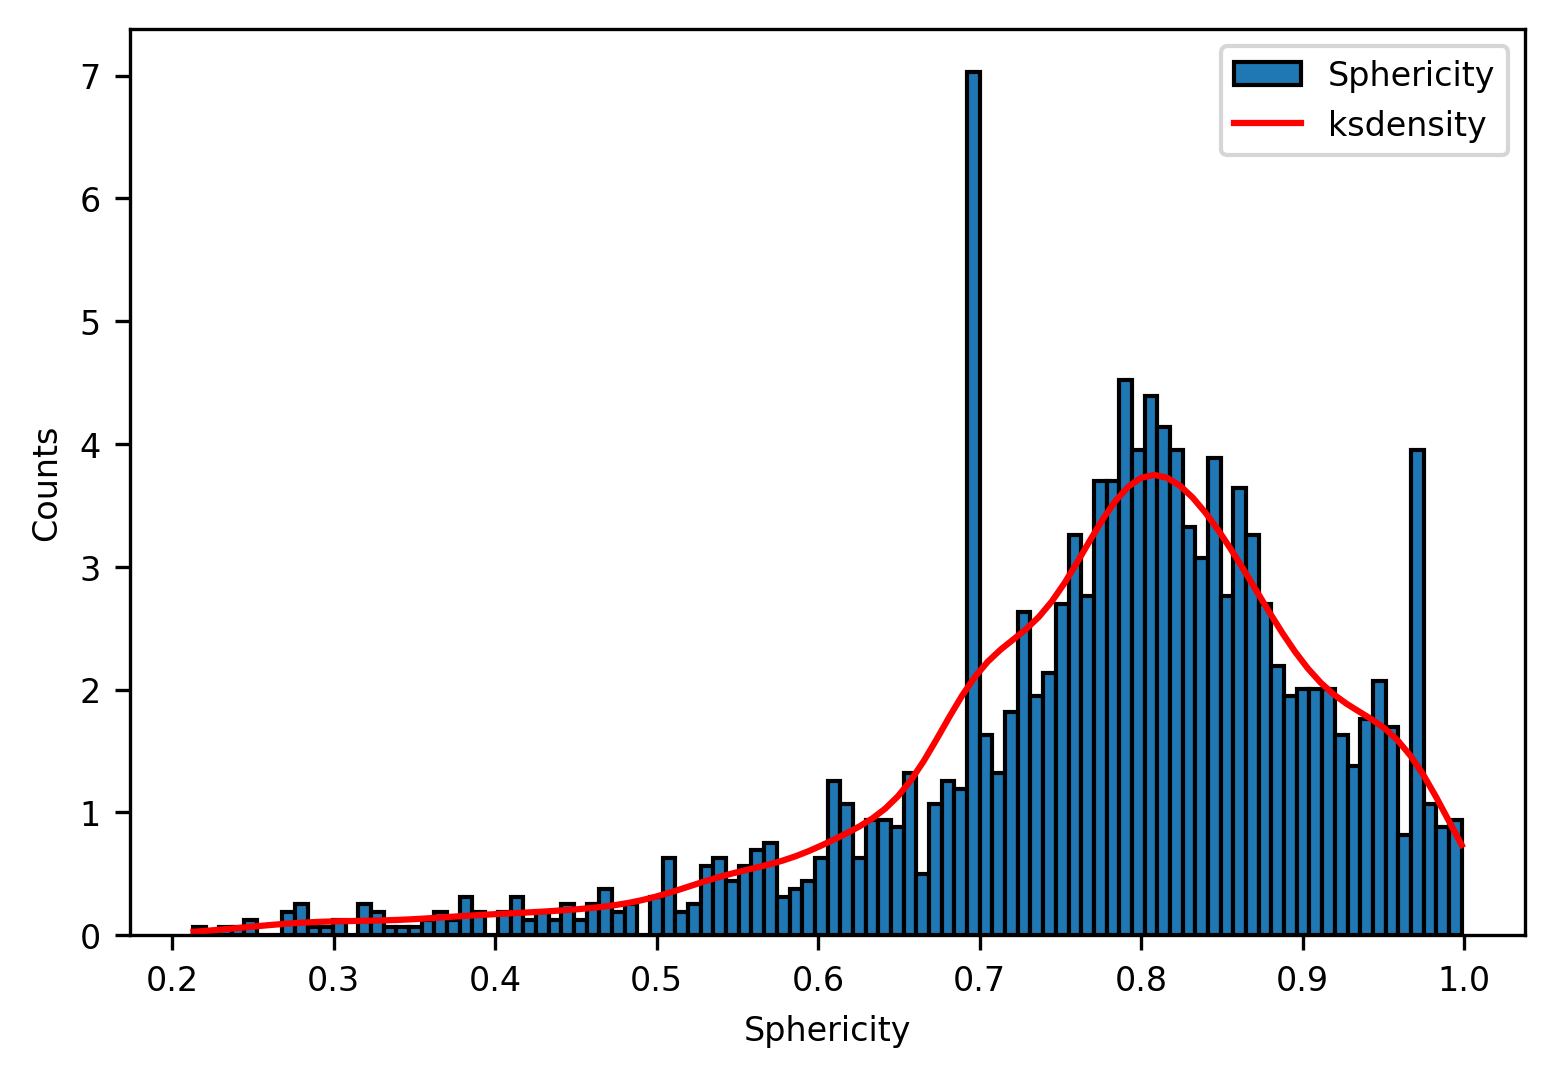

In [75]:
plt.hist(df['sphericity'], bins=100, edgecolor="k", density=True, label='Sphericity');
plt.plot(x, p, 'r', label='ksdensity')
plt.ylabel("Counts")
plt.xlabel("Sphericity")
plt.legend()
plt.show()

In [76]:
from scipy.signal import find_peaks

In [77]:
sphericity_peaks = find_peaks(p)

In [82]:
x[sphericity_peaks[0]]

array([0.80807822])

In [30]:
# find particle with largest volume
df_invalid[df_invalid["volume"] == df_invalid["volume"].max()]

,label,volume,bbox_volume,sphericity,surface_area,convex_volume,area,area_bbox,area_convex,equivalent_diameter_area,euler_number,extent,area_filled,axis_major_length,solidity
259,260,3859,7360,1.008943,1179.236328,4135,3859,7360,4135,19.460712,1,0.524321,3859,22.638862,0.933253


In [32]:
# get dataframe number of rows
df_invalid.shape[0]

338

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].imshow(props[20].dt[5, ...]);


---
#### Some porespy stuff
- Apply_padded function

In [159]:
func = ndimage.binary_fill_holes

In [156]:
BW_pit2 = ps.filters.apply_padded(im=~BW_pit2, pad_width=1, func=func, pad_val=1)